In [1]:
import os
import pandas as pd

data_path = 'pg/'
movies_filename = 'routes.csv'
ratings_filename = 'route_ratings.csv'

In [2]:
# read data
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),

    usecols=['route_id', 'route_name'],
    dtype={'route_id': 'int32', 'route_name': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['user_id', 'route_id', 'rating'],
    dtype={'user_id': 'int32', 'route_id': 'int32', 'rating': 'float32'})


In [3]:
df_movies.head()
df_movies.shape

(72, 2)

In [4]:
df_ratings.head()


,route_id,user_id,rating
0,65,4,3.0
1,63,4,2.0
2,53,4,5.0
3,65,13,1.0
4,148,13,3.0


In [5]:


# df_ratings.shape
df_ratings=df_ratings[:2000000]

df_ratings.shape

(41, 3)

In [6]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot_table(
    index='route_id',
    columns='user_id',
    values='rating', aggfunc='mean'
).fillna(0)


In [7]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [8]:
df_movie_features.head()

user_id,4,13,38,56,57
route_id,,,,,
53,5.0,4.0,0.0,0.0,0.0
63,2.0,0.0,0.0,0.0,0.0
64,0.0,0.0,2.0,0.0,0.0
65,3.0,1.0,0.0,0.0,1.0
72,0.0,0.0,0.0,0.0,1.0


In [9]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=1, n_jobs=-1)

In [10]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.route_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 5 unique users and 20 unique movies in this data set


In [11]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1.0,9
2.0,6
3.0,12
4.0,5
5.0,9


In [12]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,59
1.0,9
2.0,6
3.0,12
4.0,5
5.0,9


In [13]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,59,4.077537
1.0,9,2.197225
2.0,6,1.791759
3.0,12,2.484907
4.0,5,1.609438
5.0,9,2.197225


Text(0, 0.5, 'number of ratings')

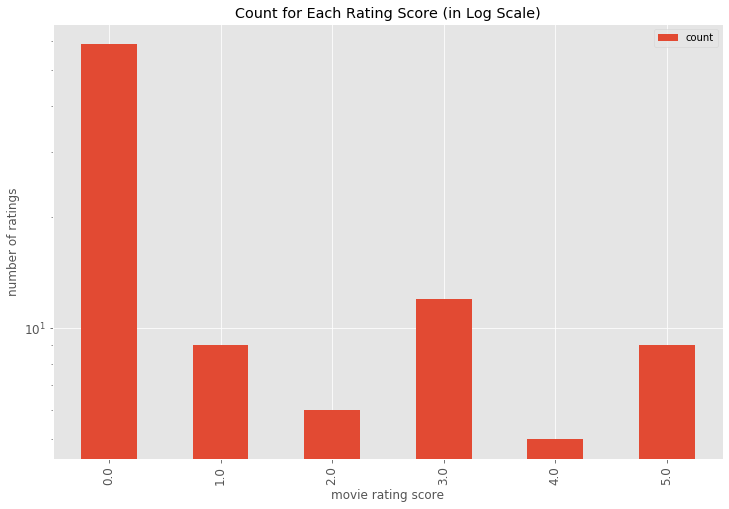

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [15]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('route_id').size(), columns=['count'])
df_movies_cnt.head()

,count
route_id,
53,4
63,1
64,1
65,3
72,1


In [16]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it

popularity_thres = 2
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.route_id.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (41, 3)
shape of ratings data after dropping unpopular movies:  (29, 3)


In [17]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
4,2
13,9
38,2
56,5
57,11


In [18]:
# filter data to come to an approximation of user likings.
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (41, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (29, 3)


In [19]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot_table(index='route_id', columns='user_id', values='rating', aggfunc='mean').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('route_id').loc[movie_user_mat.index].route_name))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [20]:
print(movie_user_mat_sparse)
movie_user_mat_sparse

(0, 0)	5.0
  (0, 1)	4.0
  (1, 0)	3.0
  (1, 1)	1.0
  (1, 4)	1.0
  (2, 1)	3.0
  (3, 1)	5.0
  (3, 4)	5.0
  (4, 1)	5.0
  (4, 4)	5.0
  (5, 2)	3.0
  (5, 3)	3.0
  (5, 4)	2.75
  (6, 2)	4.0
  (6, 4)	3.5
  (7, 3)	1.6666666


<8x5 sparse matrix of type '<class 'numpy.float32'>'
	with 16 stored elements in Compressed Sparse Row format>

In [21]:
movie_to_idx

{'sidewalk_53': 0,
 'bus-43': 1,
 'walk_148': 2,
 'bus-145': 3,
 'bus-115': 4,
 'walk_165': 5,
 'sidewalk_166': 6,
 'walk_171': 7}

In [22]:
from fuzzywuzzy import fuzz

In [23]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [24]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    print(indices)

    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print(raw_recommends)
    print(reverse_mapper)
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [25]:
my_favorite = 'walk'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=3)

You have input movie: walk
Found possible matches in our database: ['walk_171', 'walk_165', 'walk_148']

Recommendation system start to make inference
......

[[7 5 6 0]]
[(0, 1.0), (6, 1.0), (5, 0.4066382050514221)]
{0: 'sidewalk_53', 1: 'bus-43', 2: 'walk_148', 3: 'bus-145', 4: 'bus-115', 5: 'walk_165', 6: 'sidewalk_166', 7: 'walk_171'}
Recommendations for walk:
1: sidewalk_53, with distance of 1.0
2: sidewalk_166, with distance of 1.0
3: walk_165, with distance of 0.4066382050514221


In [26]:
movie_to_idx

{'sidewalk_53': 0,
 'bus-43': 1,
 'walk_148': 2,
 'bus-145': 3,
 'bus-115': 4,
 'walk_165': 5,
 'sidewalk_166': 6,
 'walk_171': 7}